In an ideal world I'd write this notebook in the tool I'm talking about and share it on my website that way. Unfortunately I haven't been able to find an extension for [Quarto](https://quarto.org) (which I use to build the website) that handles [marimo notebooks](https://docs.marimo.io)^[Yet... and it may never happen, given the investment of [Posit](https://posit.co) in [Shiny](https://shiny.posit.co)], which is the tool in question.

So what's a marimo notebook? The easiest way to think about it is as a _reactive_ Python notebook. I've been using [Jupyter notebooks](https://jupyter.org) since forever. I first taught with them in 2016 at Berkeley as a contribution to the then nascent [major in Data Science](https://cdss.berkeley.edu/dsus/academics/data-science-major) there. Since then I've taught python programming using Jupyter notebooks as the platform.

That's a good choice in some ways, but a bad one in others. The good is that you can introduce code in the context of working code for students to modify and get comfortable with, in a managed, predictable environment (unlike the wild west that is most student laptops). The bad reason is that Jupyter notebooks can get in a terrible tangle if you run the code cells out of sequence. Almost invariably when a student runs into problems (or for that matter _I_ run into a problem) using a notebook, it's because ~~they~~ I have been jumping back and forward running cells, forgetting that this will put the notebook into a weird state and break things. 

It's not unreasonable for students to expect a change anywhere in their code anywhere in a notebook to affect every other part of the notebook that uses affected variables and their values. In other words, for the notebook to 'react' to all changes. This enhanced interactivity is what marimo notebooks offer.

## Jupyter notebooks
Anyway, if you are unfamiliar, this page is built from a [Jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/index.html). More accurately, _most_ of it is, but I'll get to that. 

This being a notebook, I can mix [_markdown_ text]() such as this text you are reading, with _code cells_ like this:

In [1]:
%matplotlib inline
import random
import math
import matplotlib.pyplot as plt
import pandas as pd

That cell imports some python modules that I have installed locally, and now I can write python code using them, and run it interactively (locally) in a browser (or suitable coding environment like Visual Studio Code). For example, I can define a random point class `RandomPoint` and a function for generating a collection of points using the 'blue noise' method I described in a [previous post](https://dosull.github.io/posts/2025-01-13-random-points-on-globe-revisited/random-points-on-globe.html).

In [2]:
class RandomPoint():

    def __init__(self):
        self.x = random.random()
        self.y = random.random()

    def distance2(self, pt):
        dx = min(self.x - pt.x, 1 - self.x + pt.x)
        dy = min(self.y - pt.y, 1 - self.y + pt.y)
        return dx**2 + dy**2
        
def spaced_points(n=100):
    pts = [RandomPoint()]
    for i in range(1, n):
        n_candidates = math.ceil(math.log(1.1 * i * math.e))
        p_new = [RandomPoint() for _ in range(n_candidates)]
        d_mins = [min([p.distance2(p0) for p0 in pts]) for p in p_new]
        i_max = max(enumerate(d_mins), key=lambda x: x[1])[0]
        pts.append(p_new[i_max])
    return pd.DataFrame(data = {'x': [p.x for p in pts], 
                                'y': [p.y for p in pts]})

And I can make a point pattern and plot it.

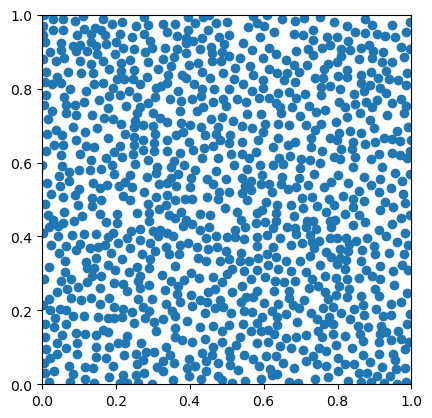

In [3]:
pp = spaced_points(1000)
scatter = plt.scatter(x=pp.x, y=pp.y)
scatter.axes.set_aspect(1)
scatter.axes.set_xlim(0, 1)
scatter.axes.set_ylim(0, 1)
plt.show()

What you are seeing here is the output of my code parsed to produce a static web page in HTML. You can also parse notebooks to make PDFs, Word documents, and so on.

## Interactive Jupyter
The experience of using Jupyter notebooks is highly interactive _for the author_ of the notebook. That quickly leads to wanting to put together notebooks that are interactive _for the end user_. That's a little bit more complicated to code, but not by much, using the `ipywidgets` module.

If I wrap the plotting code above in a function that takes as inputs a point pattern `pp` and the number of points `n` to plot, then using components from the `ipywidgets` module, I can control how many points in the pattern are displayed, so that I can see the progression of the generating function as points are added.

In [5]:
import ipywidgets as widgets
from ipywidgets import interactive, fixed

def plot_spaced_points(pp:pd.DataFrame, n:int):
  scatter = plt.scatter(x=pp.x[:n], y=pp.y[:n])
  scatter.axes.set_aspect(1)
  scatter.axes.set_xlim(0, 1)
  scatter.axes.set_ylim(0, 1)
  plt.show()
  return None

pp = spaced_points(1000)
num_pts = widgets.IntSlider(value=100, min=10, max=pp.shape[0], step=5)
interactive(plot_spaced_points, pp=fixed(pp), n=num_pts)

interactive(children=(IntSlider(value=100, description='n', max=1000, min=10, step=5), Output()), _dom_classes…

And it works. For me. Locally. Here's a video to prove it!

{{< video interactive-jupyter.mp4 width='600px' >}}

What's much more difficult to arrange is hosting this interactive notebook in an online environment so that end users can interact with it like I can. For that I need to set up some kind of [server infrastructure](https://docs.jupyter.org/en/latest/projects/deployment.html), or use an environment such a [Google Colab](https://colab.research.google.com/), or [CoCalc](https://cocalc.com/), [Azure Notebooks](https://notebooks.azure.com/), or [SaturnCloud](https://saturncloud.io/).

Setting up your own infrastructure is technically demanding involving scary sounding tools like [Kubernetes](https://kubernetes.io/). It's by no means impossible, but you need good people to set things up, and security [can be a concern](https://jupyterhub.readthedocs.io/en/latest/tutorial/getting-started/security-basics.html).

The hosted environments can be a useful alternative, but they can also be limited by low power cores, or limited storage (on free tiers), or can get quite pricey quickly if you need more oomph, or want multiple users at a time (this is a common problem getting Jupyter notebooks into the lab in New Zealand universities). 

## Enter marimo
This is where marimo comes in. Below is a marimo notebook embedded in a HTML `iframe`.

You can drag the slider to see the number of points in the plot change. You can even edit the code blocks to make changes to the code. 

The magic here is [:WebAssembly (WASM)](https://en.wikipedia.org/wiki/WebAssembly) which my python 'source code' has been compiled to via the [Pyodide](https://pyodide.org/) project. Because the resulting HTML page is in WebAssembly it runs in the browser, not on a python kernel on a remote server, so it is effectively a static web page and I can even serve it on github pages. Here's a [more ambitious example](https://dosull.github.io/weaving-space/tiling-explorer/) from my work on tiled maps of multivariate data. Be warned it takes a little while to download (about a minute to get up and running) because it has to install a bunch of relatively chunky python modules before it will work.

<iframe src="https://dosull.gtihub.io/notebooks/meet-marimo/" width="100%" height="1000" title="Simple marimo notebook" style="border:none;"></iframe>

<iframe src='meet-marimo/index.html' width=100% height=600px></iframe>